# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [ ]:
import pandas as pd
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats


df = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
print(df[['2ndFlrSF', 'BedroomAbvGr', 'SalePrice']].head())

   2ndFlrSF  BedroomAbvGr  SalePrice
0  1.291464      0.137500   0.553334
1 -0.762109      0.137500   0.094270
2  1.320320      0.137500   0.808369
3 -0.762109      0.137500  -0.611328
4 -0.762109      1.471143   1.258931


In [2]:
df.dtypes

1stFlrSF        float64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinType1     object
BsmtUnfSF       float64
GarageArea      float64
GarageFinish     object
GarageYrBlt     float64
GrLivArea       float64
KitchenQual      object
LotArea         float64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF     float64
OverallCond     float64
OverallQual     float64
TotalBsmtSF     float64
YearBuilt       float64
YearRemodAdd    float64
SalePrice       float64
dtype: object

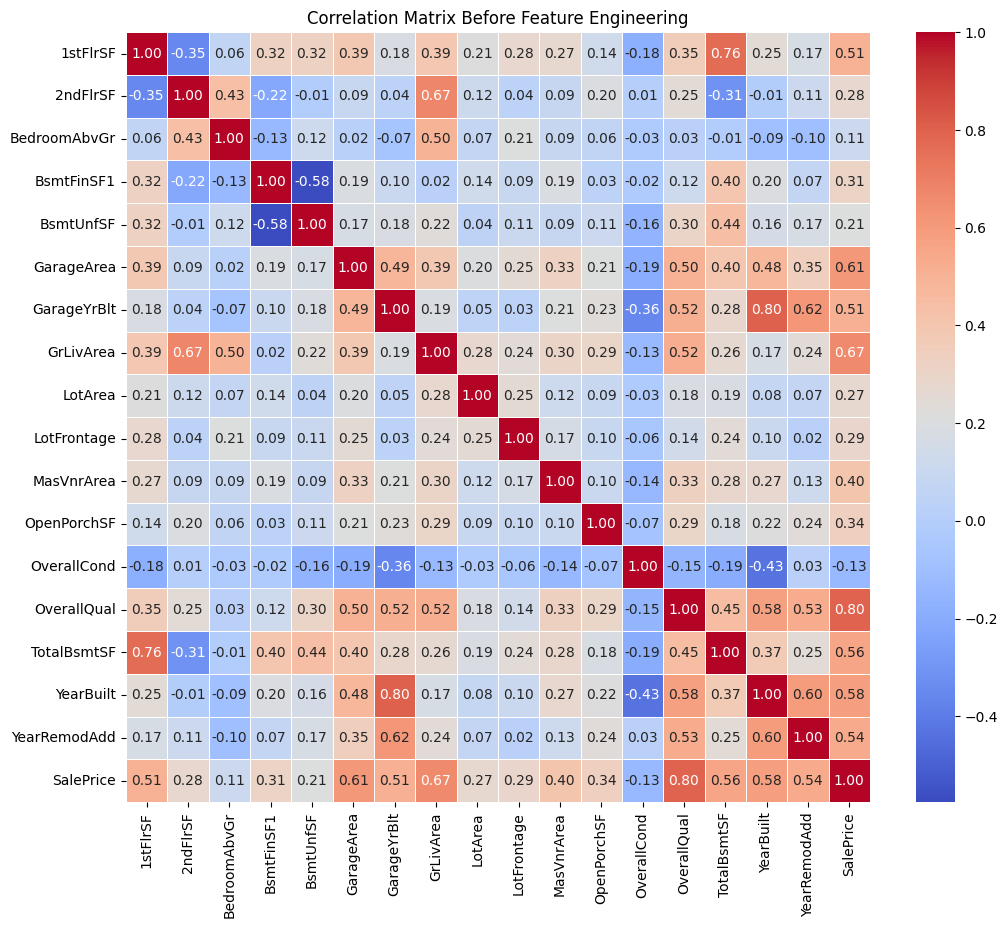

In [3]:
# Show the correlation matrix before feature engineering
correlation_matrix_before = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Before Feature Engineering")
plt.show()

**Correlation Matrix Before Feature Engineering**

The correlation matrix helps see how features relate to the target "SalePrice" before starting the feature engineering process. This helps decide which features are important and which can be combined or removed to make the model better.

Key Insights:

* **GrLivArea (0.67)** and **OverallQual (0.80)** have strong positive correalation to "SalePrice" making them important. New features could be created based on these to better capture house value.
* **GarageArea (0.61)** and **YearBuilt (0.58)** also show strong correlations, indicating that larger garages and newer construction add value.
* **BedroomAbvGr (0.11)** and **OverallCond (-0.13)** have weak links to "SalePrice". These may be improved, combined, or removed.

___

Remove features with negative correlation to SalesPrice.

In [4]:
# Filter features with negative correlation with SalePrice
negative_corr_features = correlation_matrix_before['SalePrice'][correlation_matrix_before['SalePrice'] < 0].index.tolist()

# Print features with neative correlations
print("Features with negative correlation to SalePrice:")
print(negative_corr_features)

# Remove these features from dataset
df = df.drop(columns=negative_corr_features)
print(f"Dataset shape after removing negative correlation features: {df.shape}")

Features with negative correlation to SalePrice:
['OverallCond']
Dataset shape after removing negative correlation features: (1290, 21)


In [5]:
def compare_transformations(df, variable):
    """
    Perform and visualize various transformations for a specific variable.
    """
    original = df[variable].dropna()  # Handle NaN values

    # Shift negative values for Box-Cox
    if original.min() <= 0:
        shift_value = abs(original.min()) + 1
        print(f"Shifting {variable} by {shift_value} for Box-Cox transformation.")
        original += shift_value

    transformations = {
        "Original": original,
        "Log": np.log1p(original),
        "Box-Cox": BoxCoxTransformer(variables=[variable]).fit_transform(original.to_frame())[variable],
        "Yeo-Johnson": YeoJohnsonTransformer(variables=[variable]).fit_transform(original.to_frame())[variable]
    }
    
    fig, axes = plt.subplots(len(transformations), 3, figsize=(15, 5 * len(transformations)))
    fig.suptitle(f"Transformation Analysis for {variable}", fontsize=16, y=1.02)
    
    for i, (name, transformed) in enumerate(transformations.items()):
        # Histogram
        axes[i, 0].hist(transformed, bins=30, alpha=0.7)
        axes[i, 0].set_title(f"{name} - Histogram")
        
        # QQ-plot
        stats.probplot(transformed, dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title("QQ-Plot")
        
        # Boxplot
        axes[i, 2].boxplot(transformed, vert=False)
        axes[i, 2].set_title("Boxplot")
    
    plt.tight_layout()
    plt.show()

In [15]:
print("Min value of GrLivArea before Box-Cox:", df['GrLivArea'].min())
print("Min value of TotalBsmtSF before Box-Cox:", df['TotalBsmtSF'].min())

Min value of GrLivArea before Box-Cox: 1.0000000000000002
Min value of TotalBsmtSF before Box-Cox: 1.0


Analyzing transformations for: GrLivArea


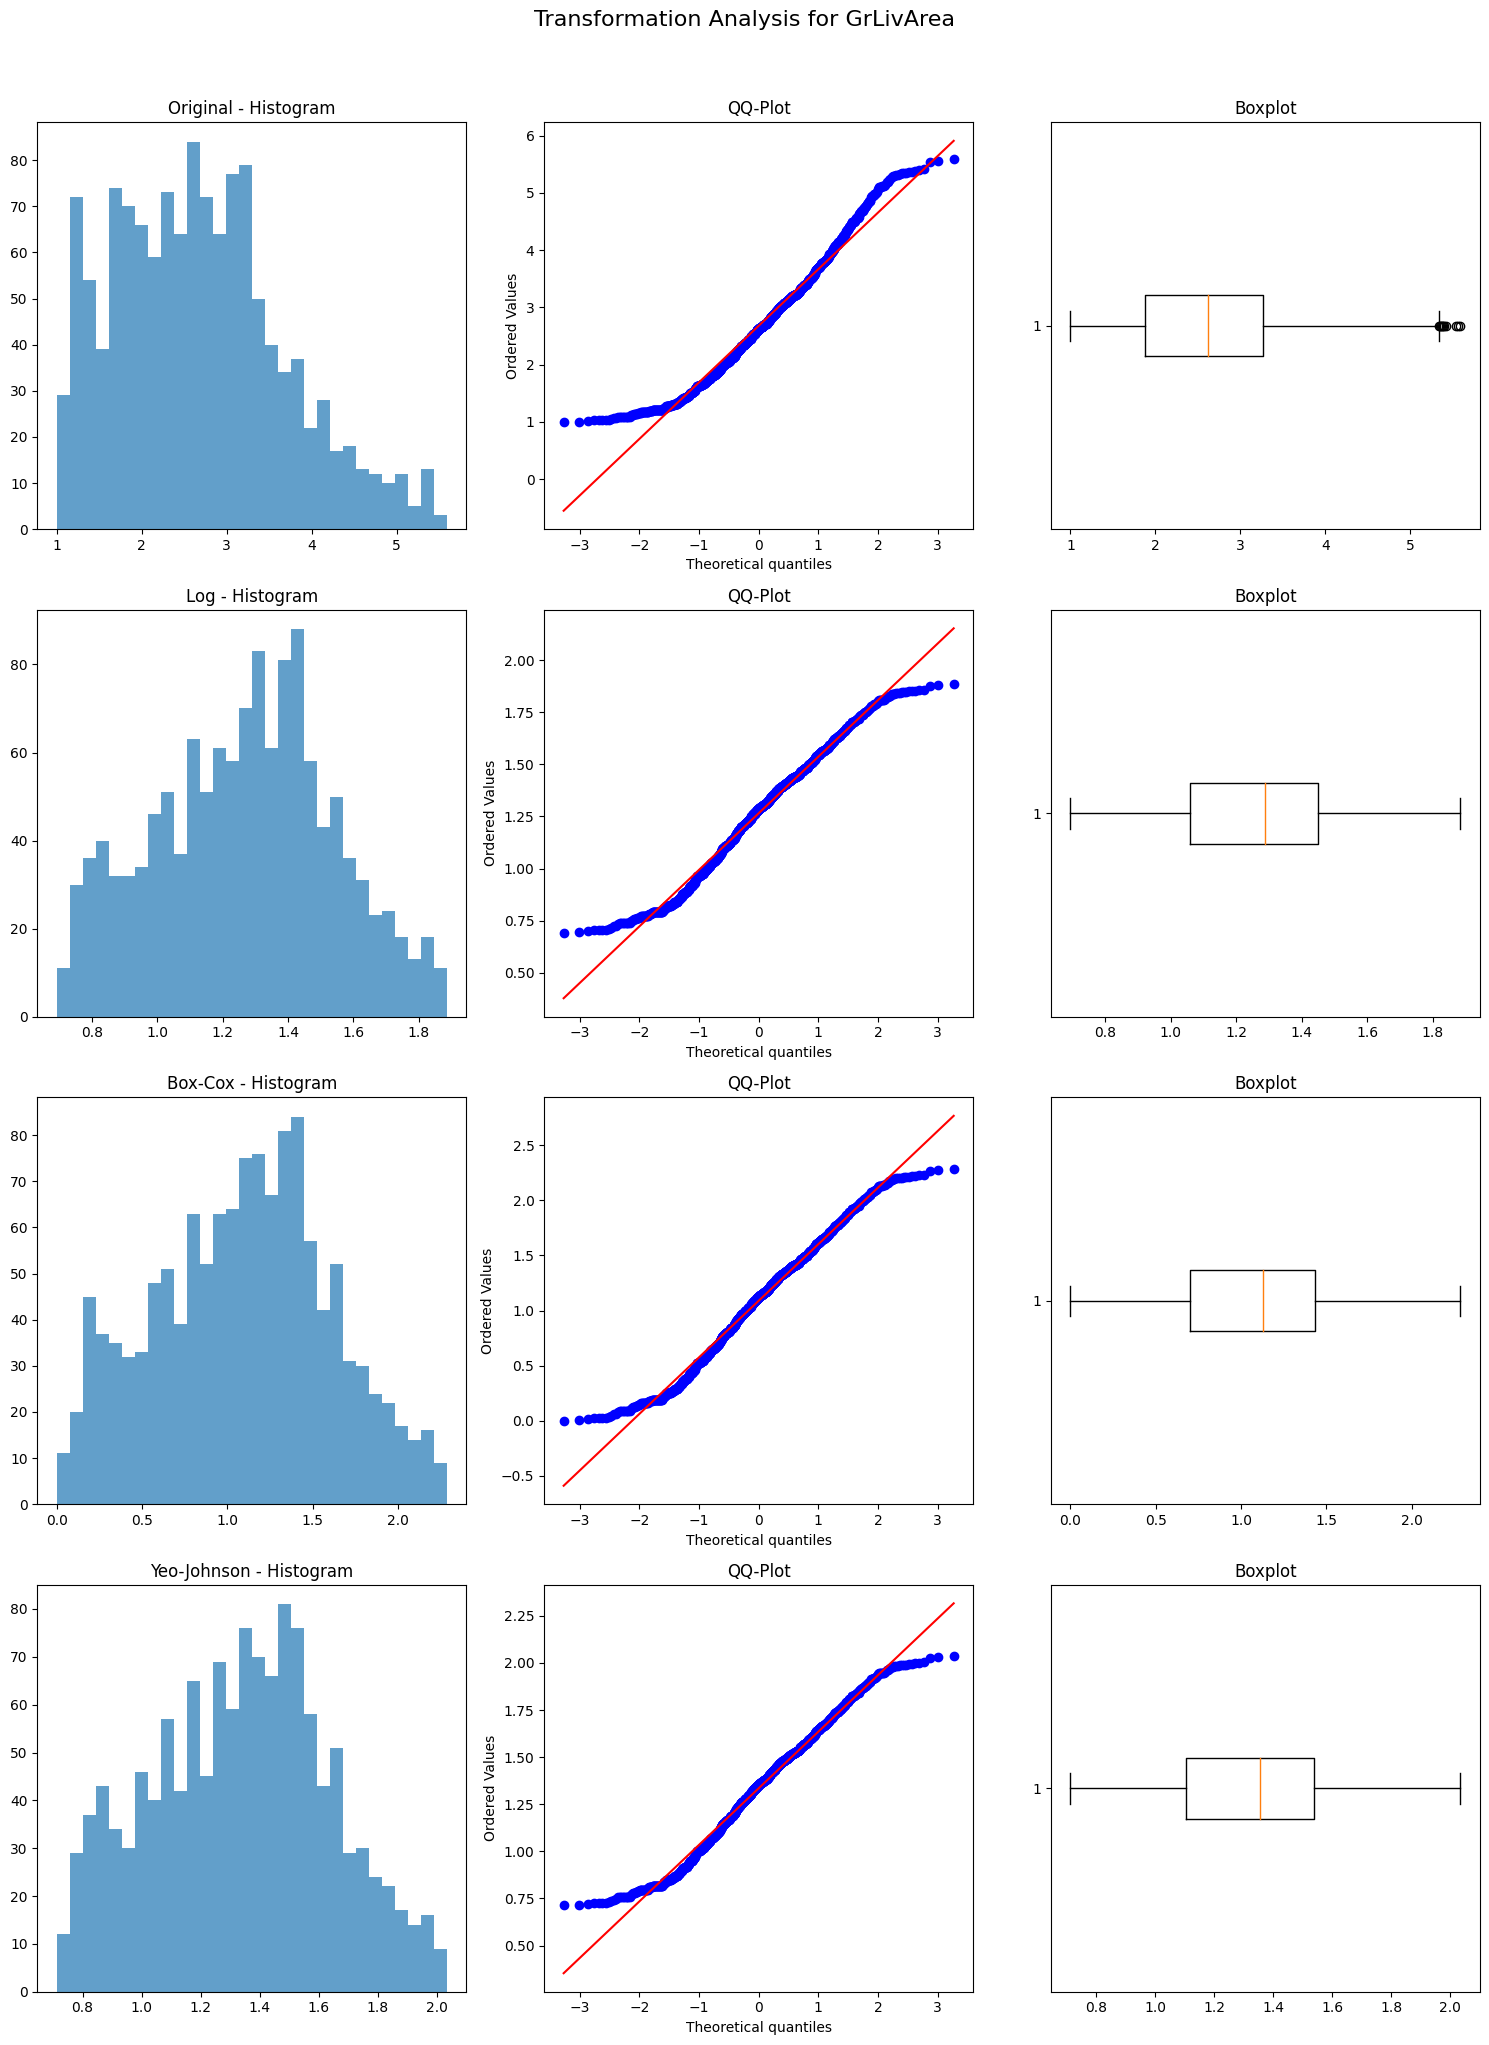

Analyzing transformations for: OverallQual
Shifting OverallQual by 3.487742468775642 for Box-Cox transformation.


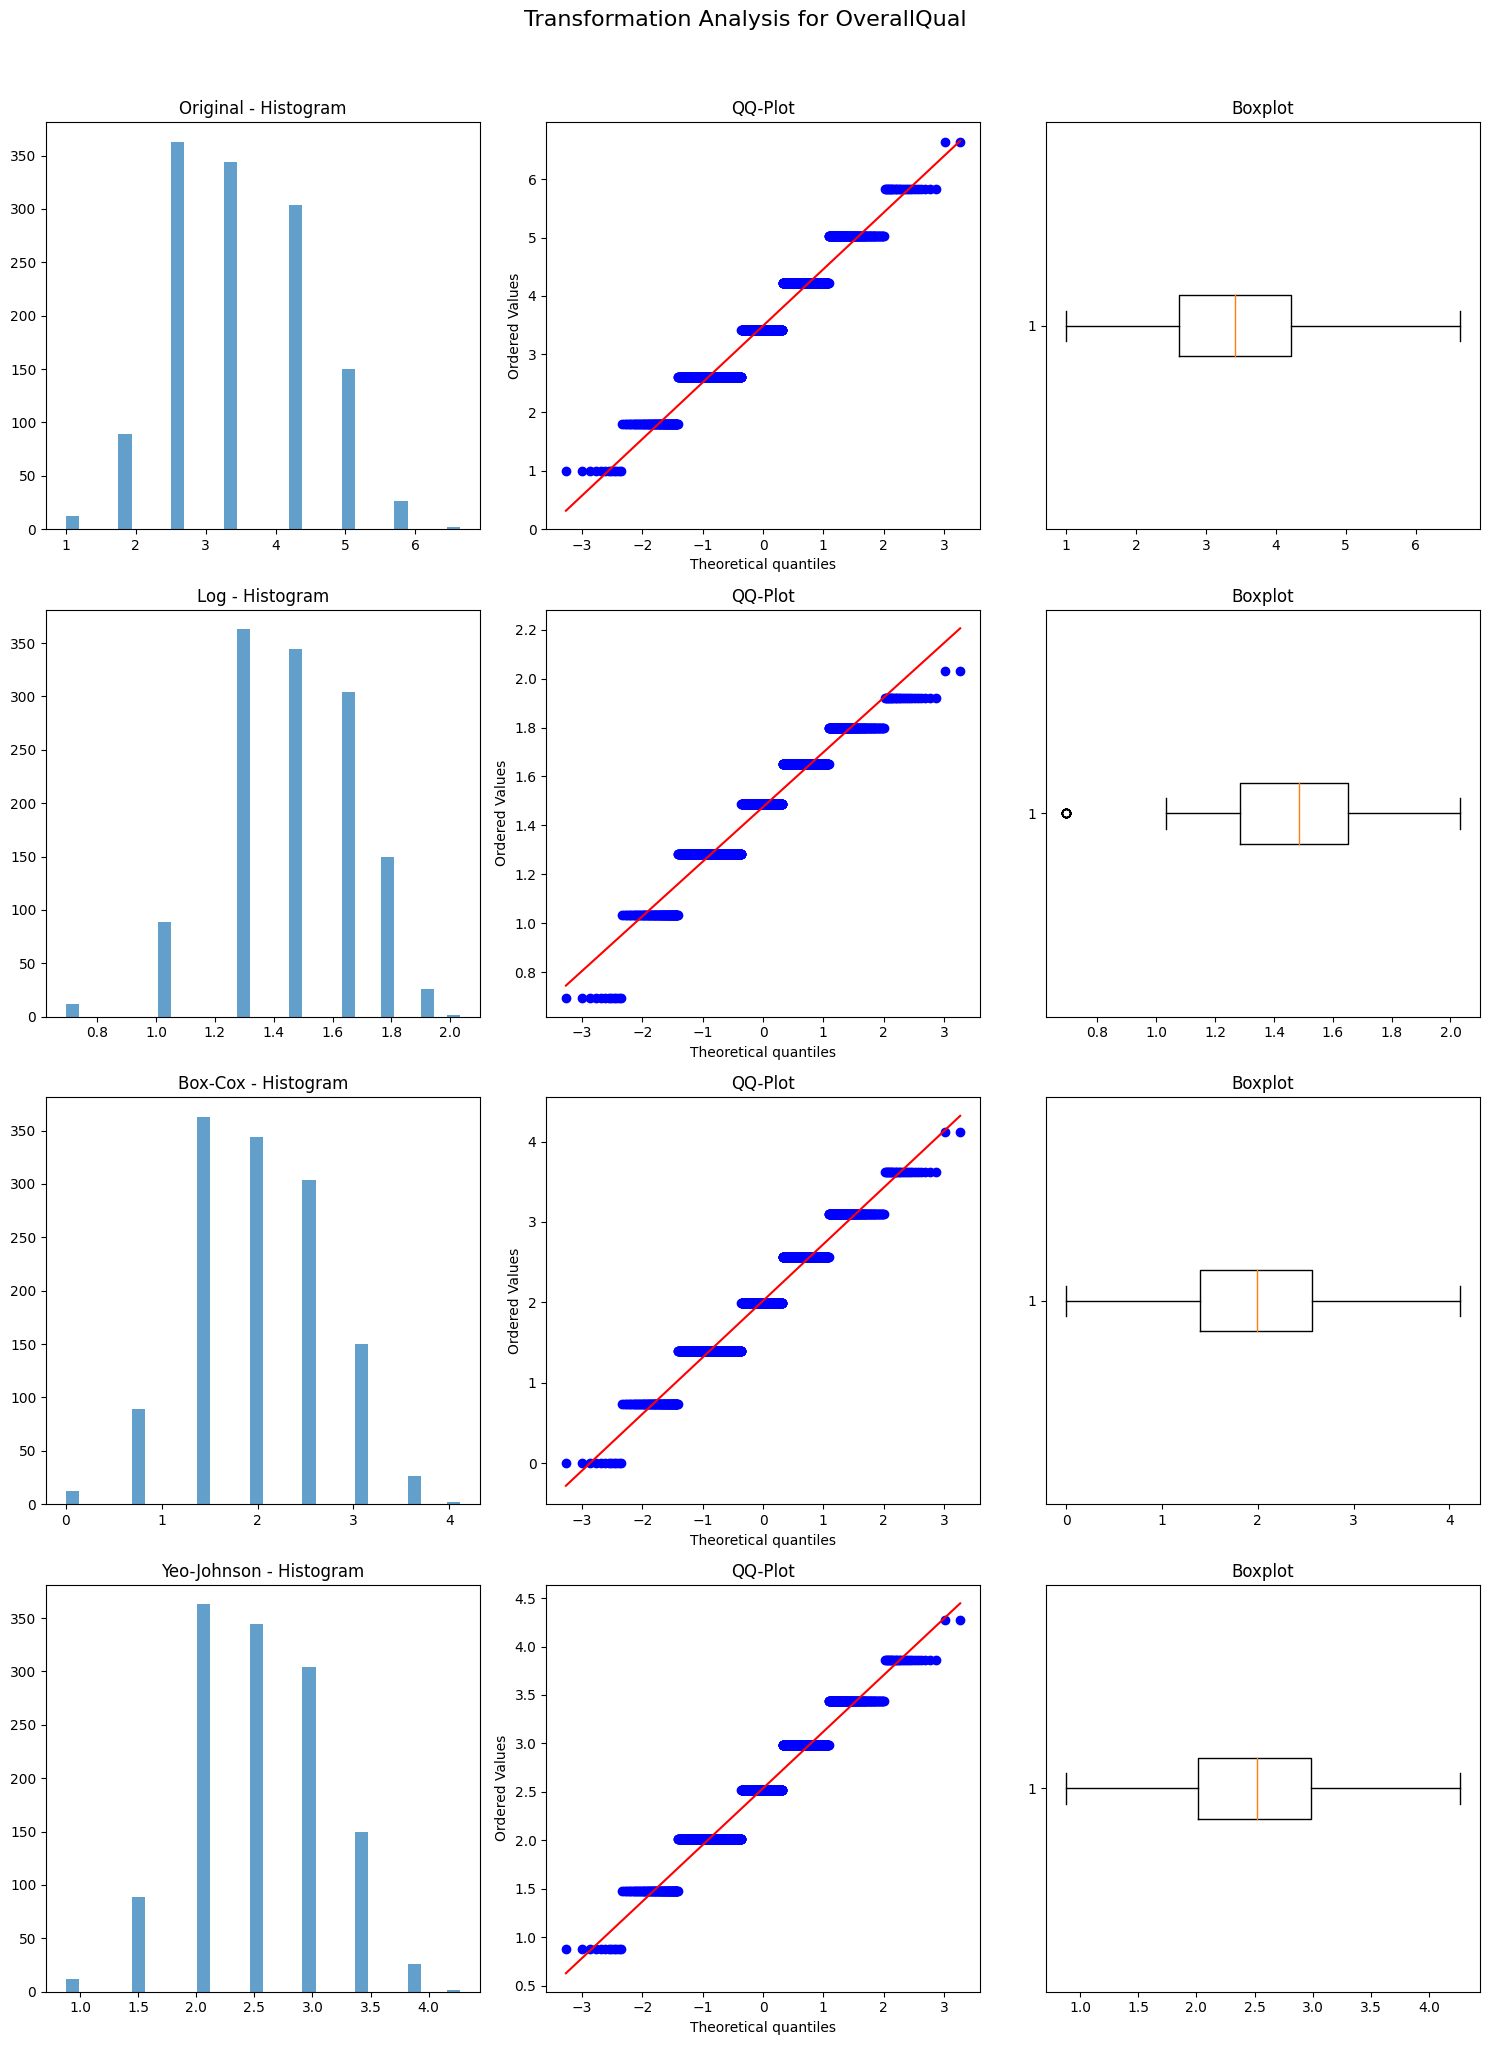

Analyzing transformations for: GarageArea
Shifting GarageArea by 3.4382106943299395 for Box-Cox transformation.


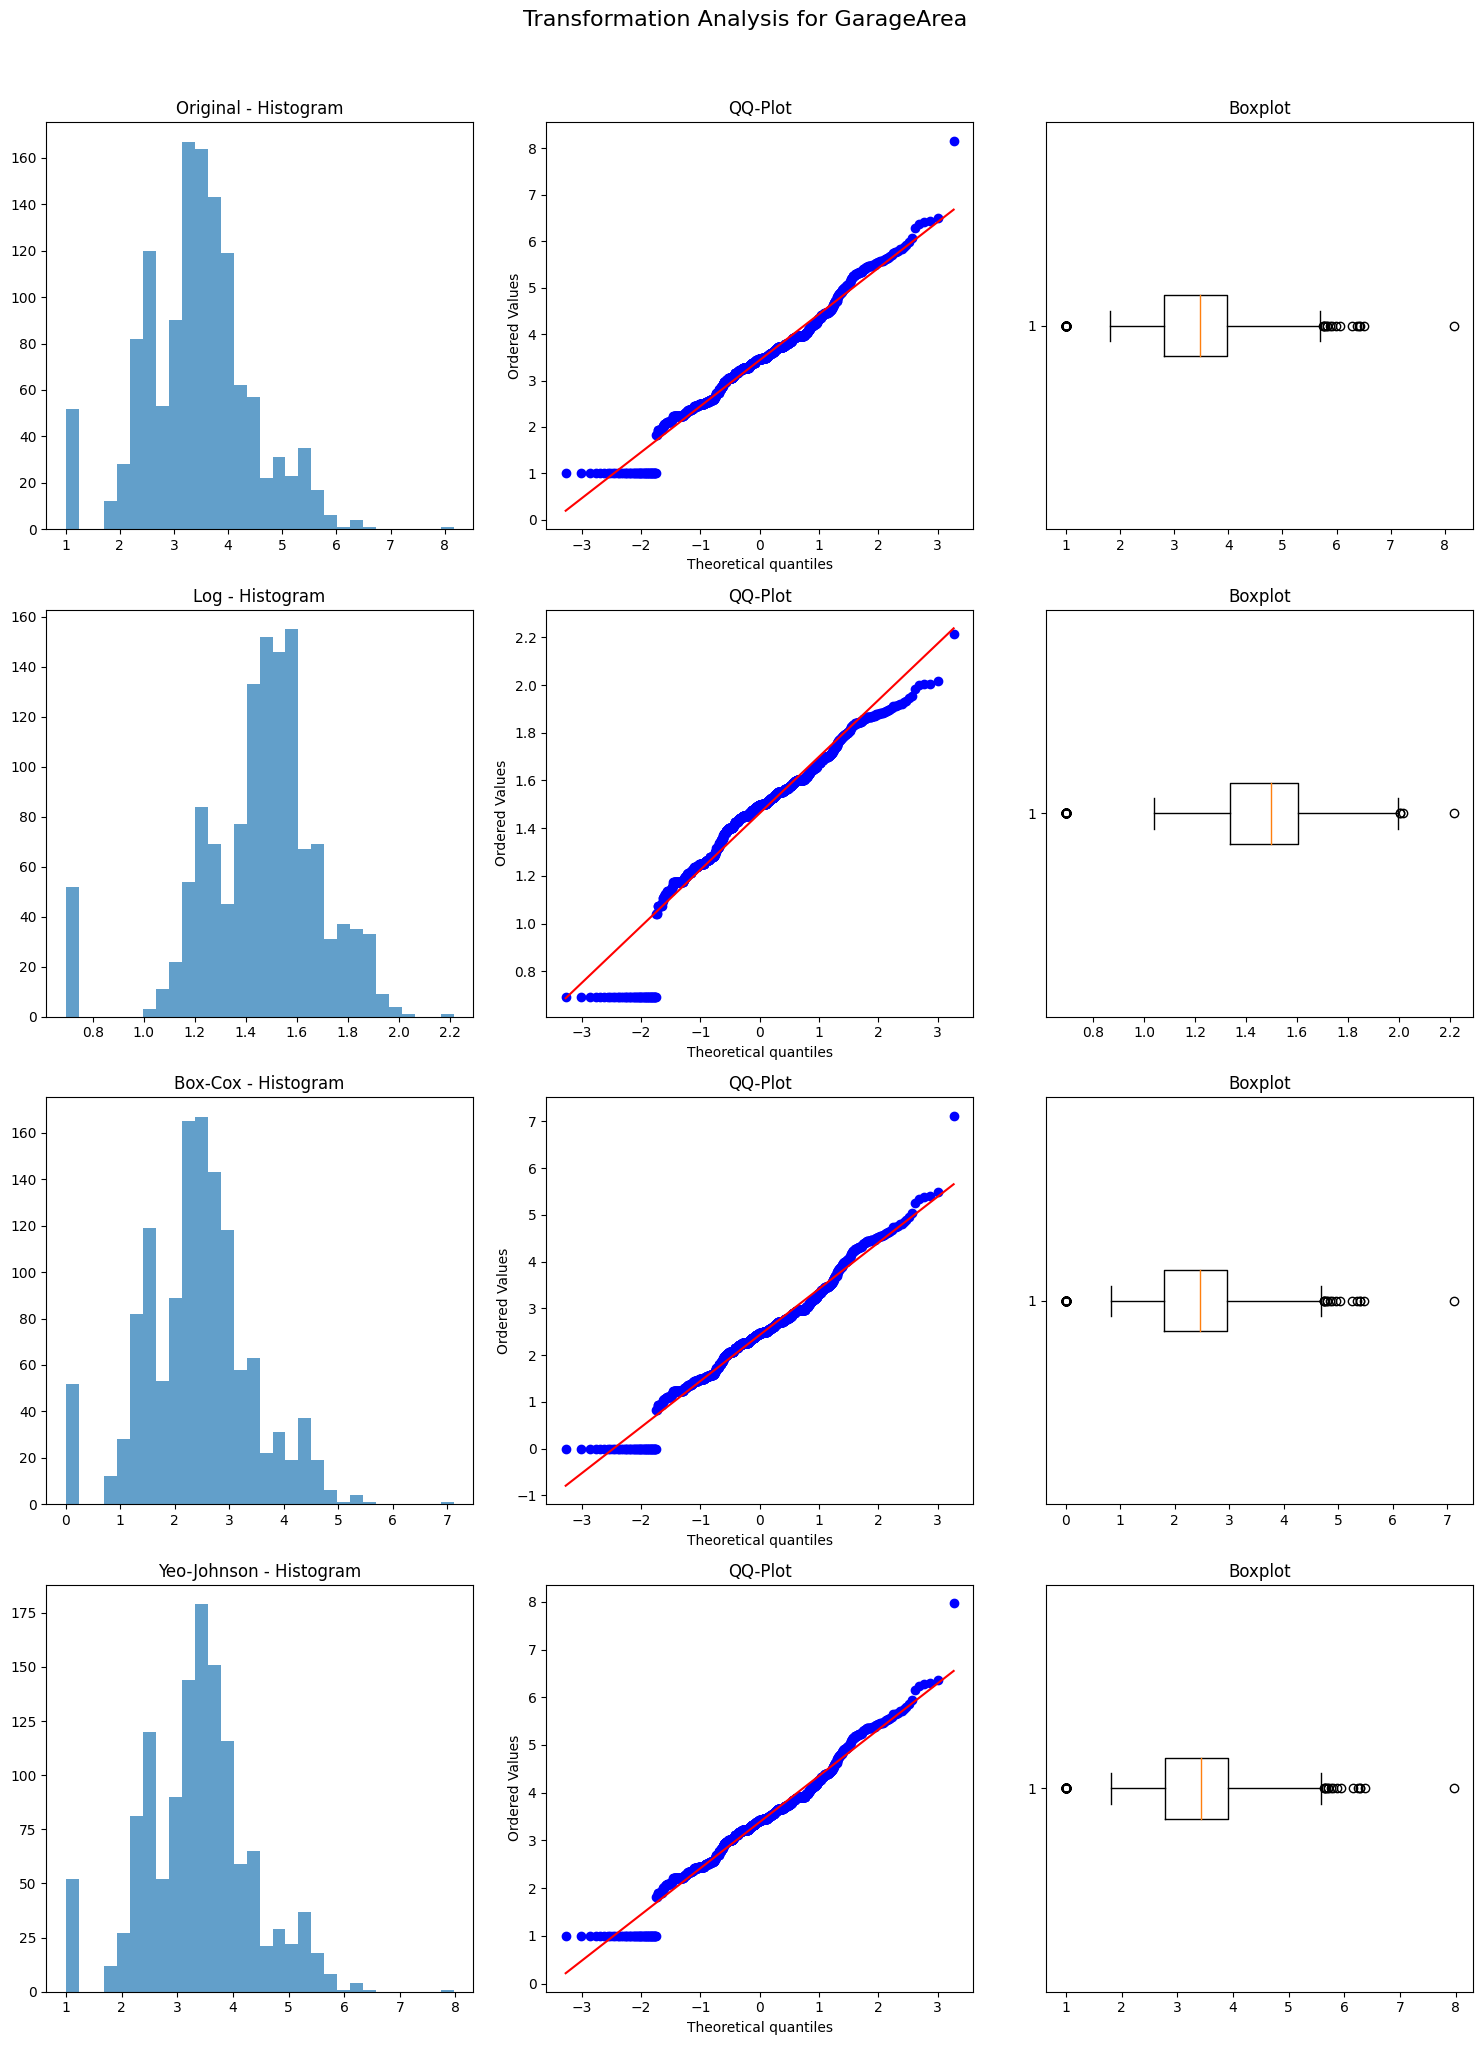

Analyzing transformations for: TotalBsmtSF


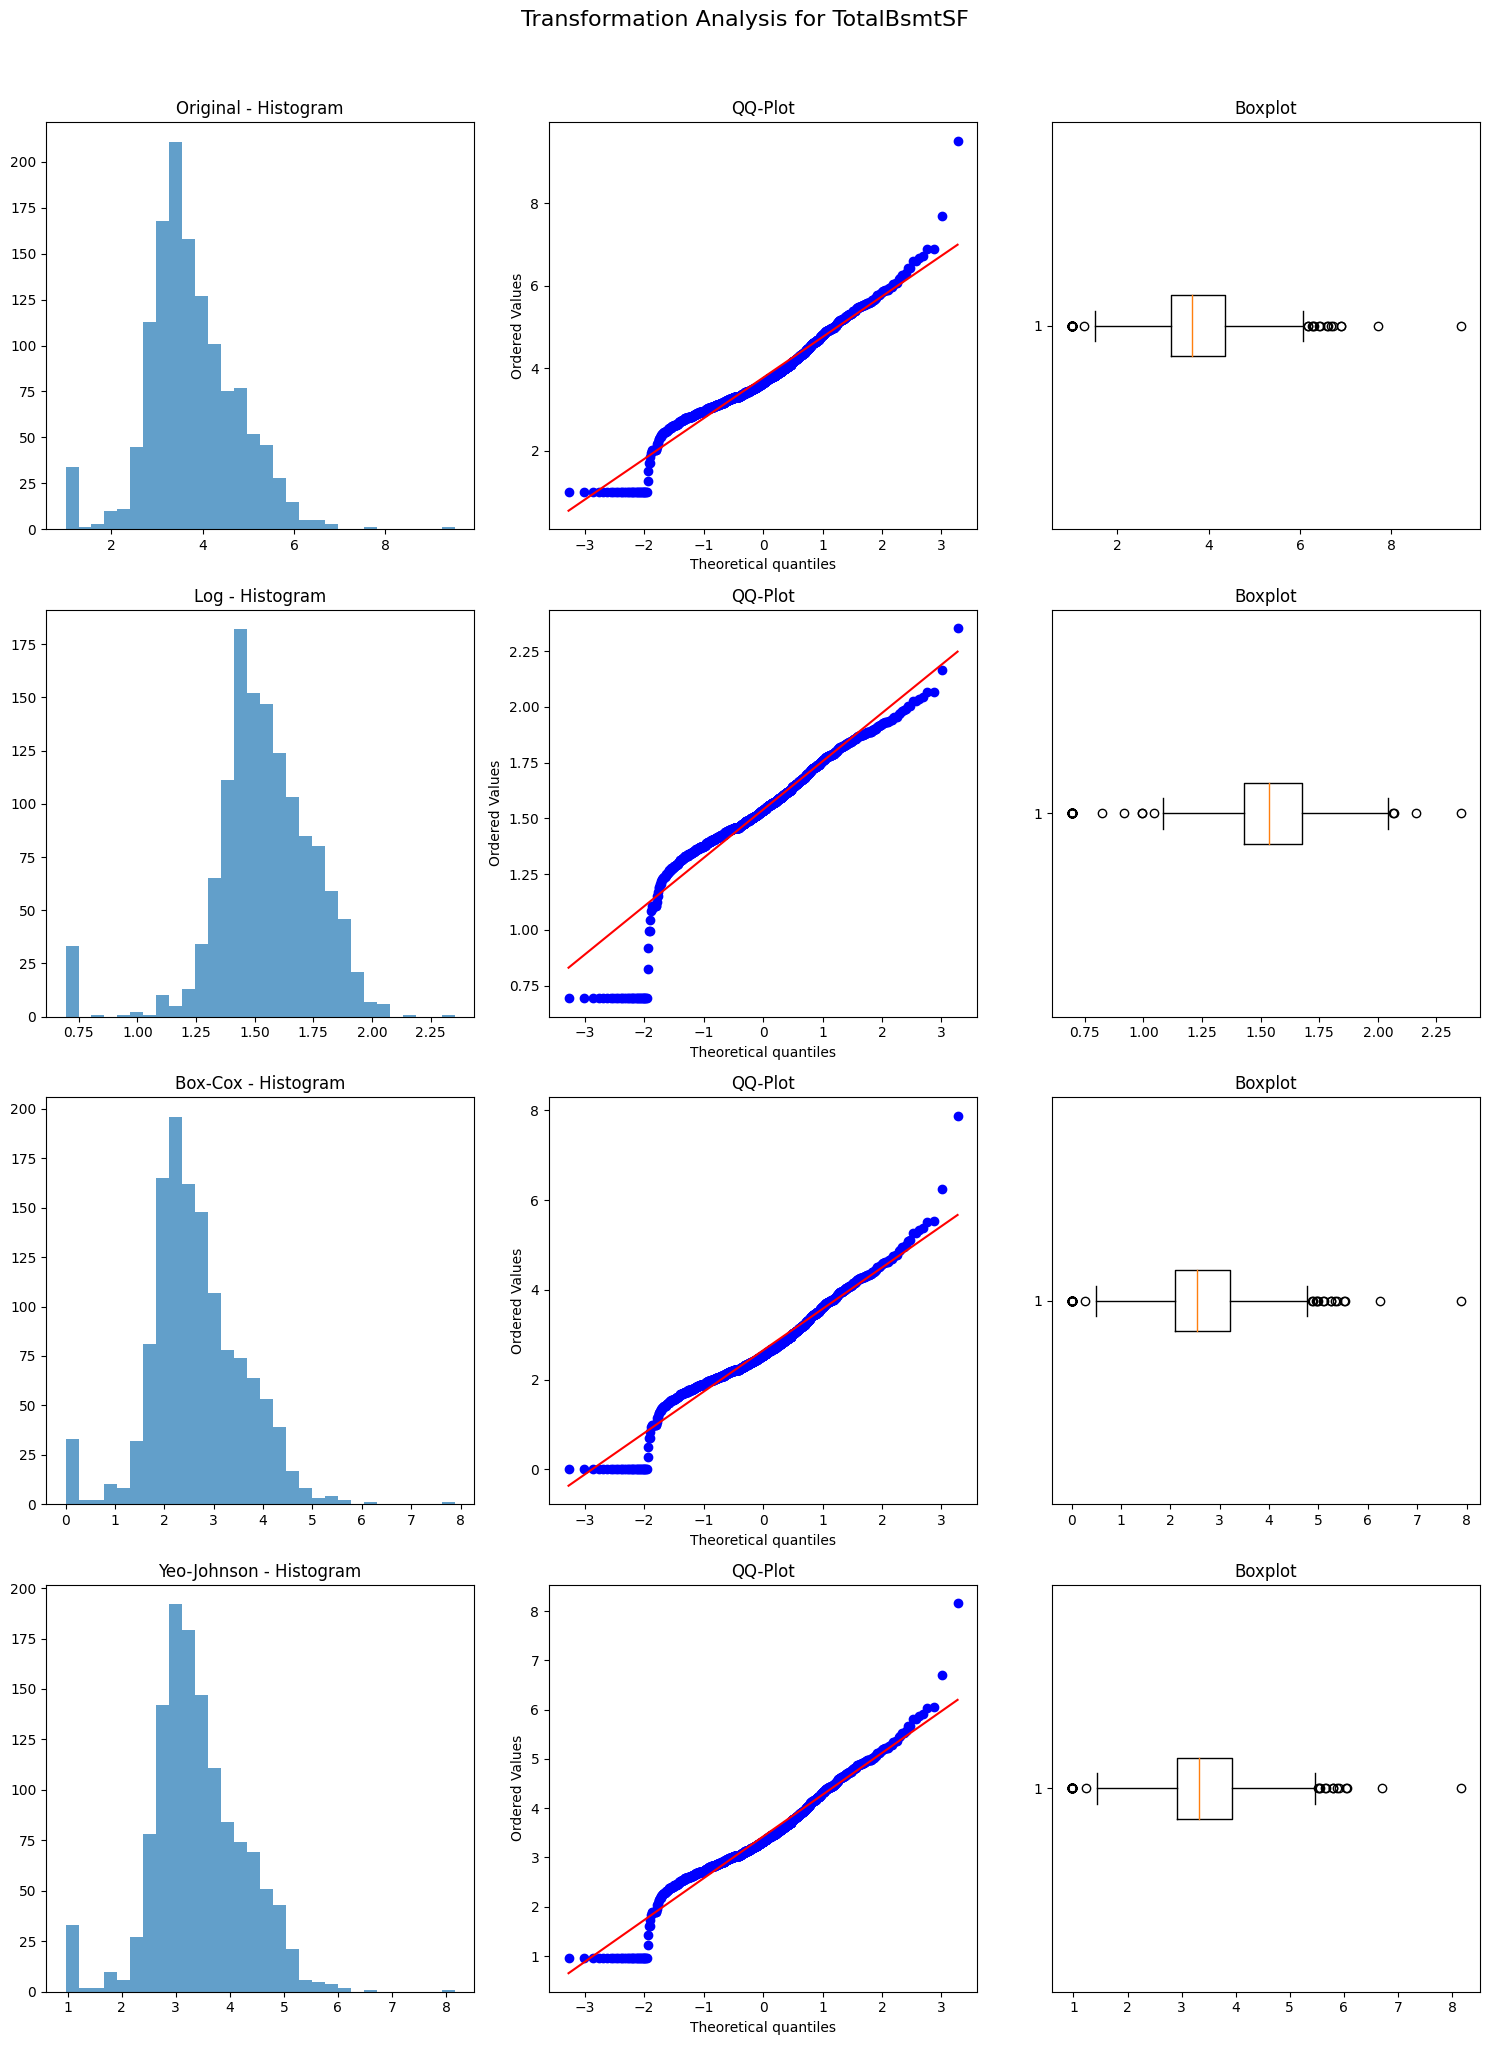

Analyzing transformations for: YearBuilt
Shifting YearBuilt by 4.366532238529093 for Box-Cox transformation.


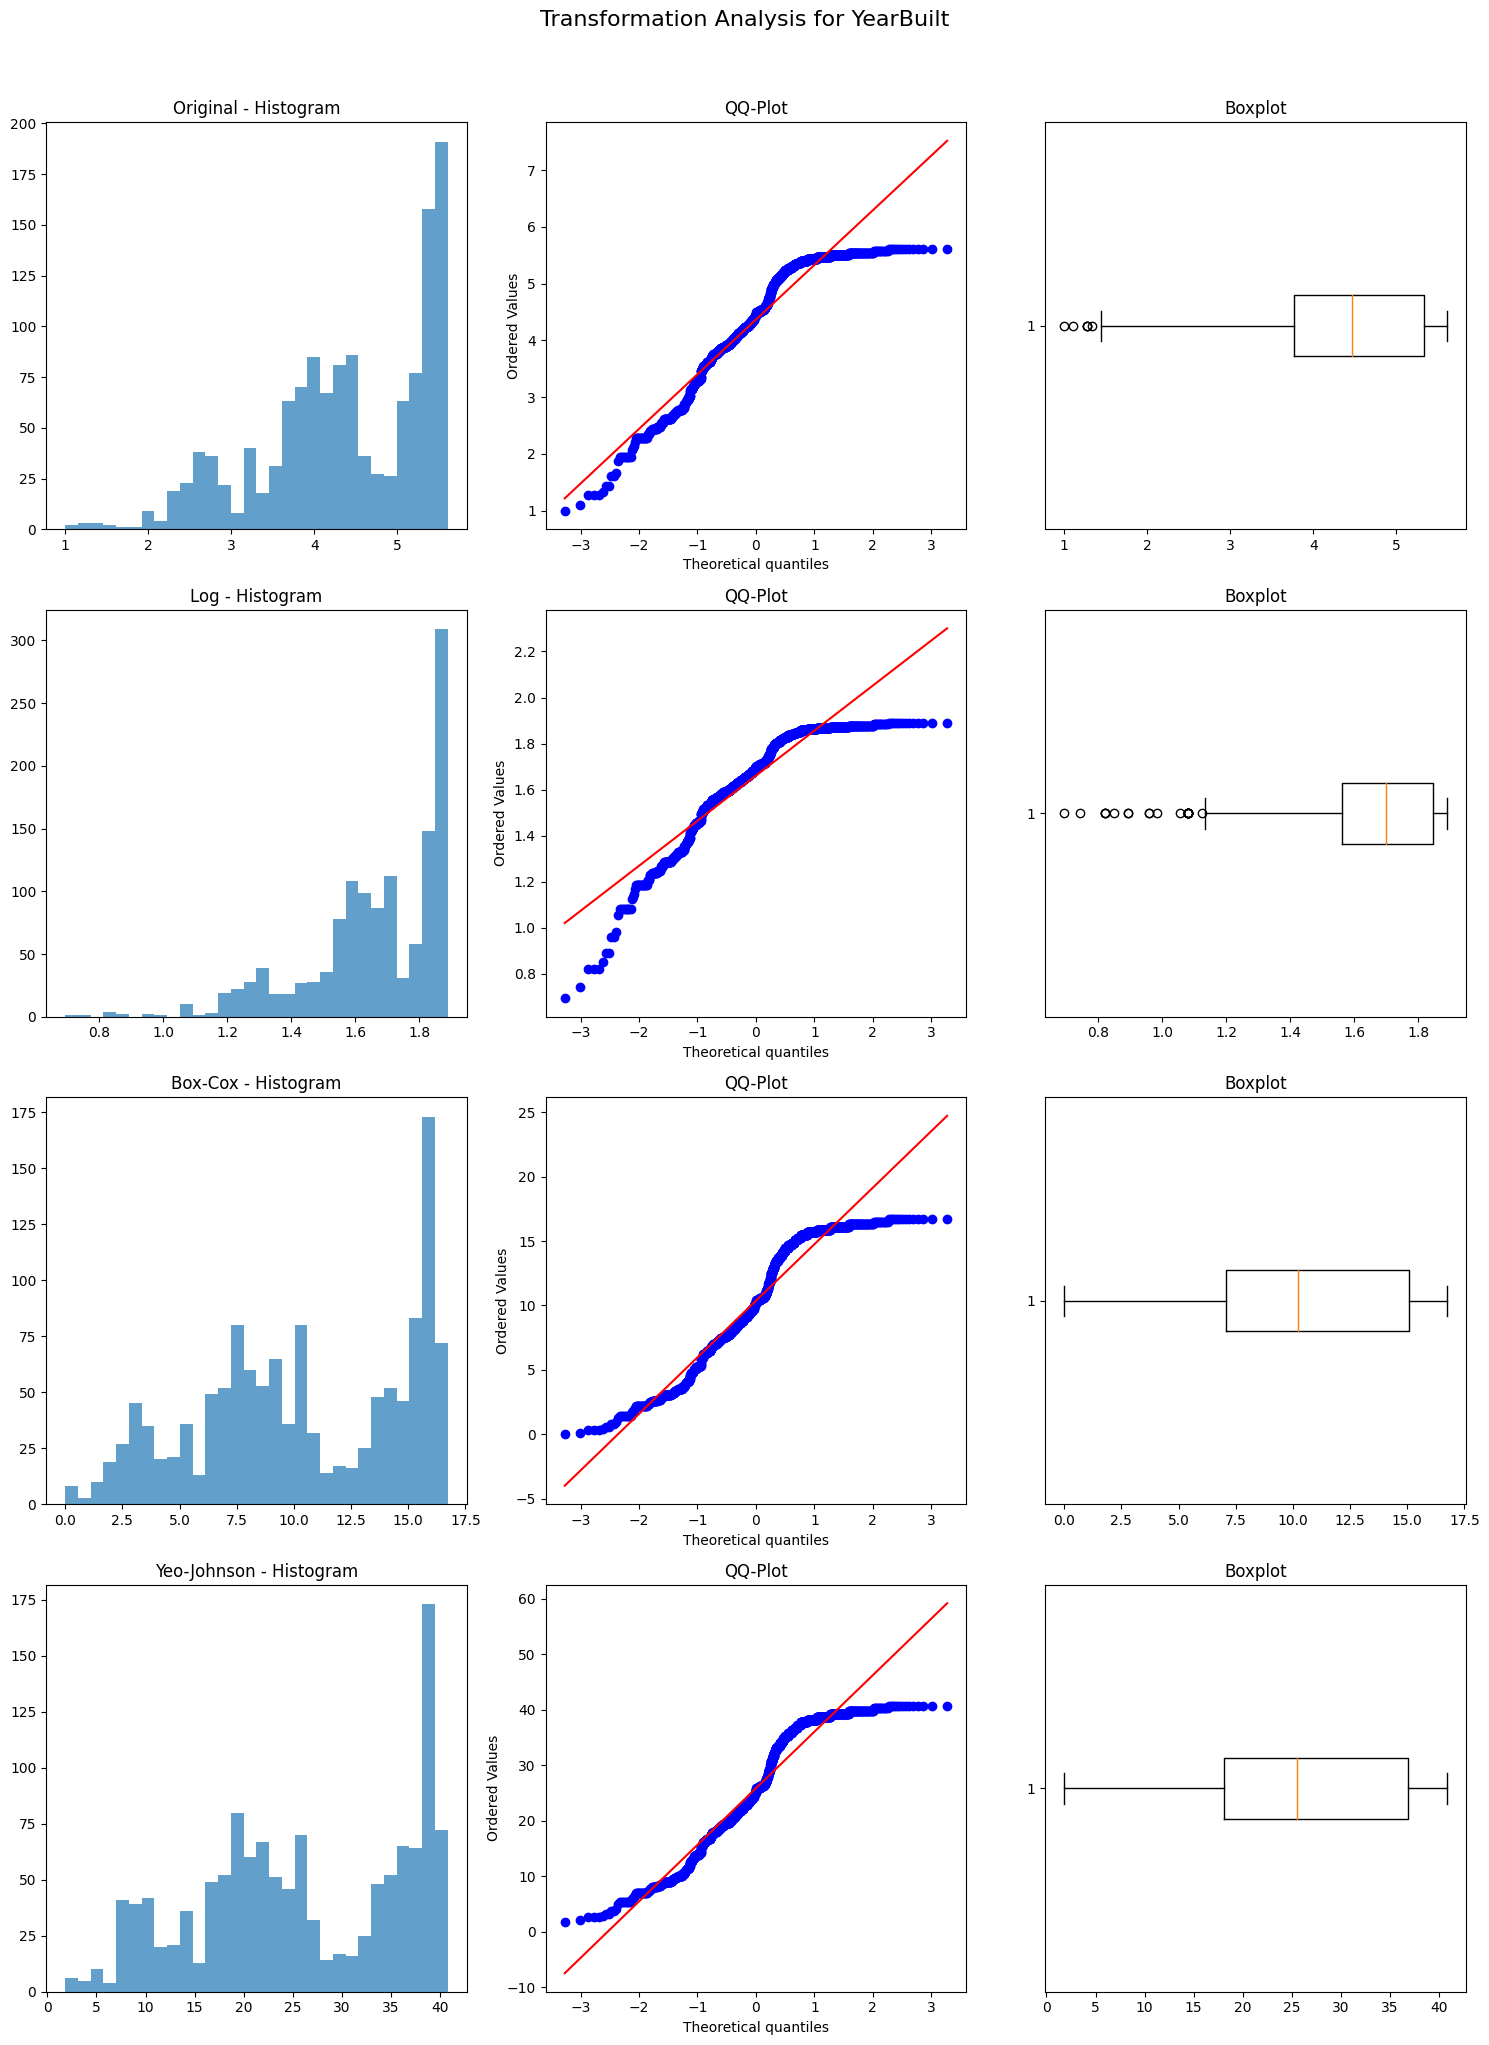

In [16]:
# Analyze transformations for strongly correlated variables
strong_corr_variables = ['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 'YearBuilt']

for variable in strong_corr_variables:
    print(f"Analyzing transformations for: {variable}")
    compare_transformations(df, variable)

* **GrLivArea** and **TotalBsmtSF** Both have skewed distributions, which can negatively affect the model. The Box-Cox transformation works well here, as it reduces skewness and the impact of extreme values. This should help the model better understand these variables.

* **OverallQual** This is a categorical variable representing house quality. Since it already has a discrete structure, transformations don’t improve it. I’m keeping it as is, as it provides meaningful levels directly to the model.

* **GarageArea** This variable has some skewness and can include zero values. Yeo-Johnson is the best choice here because it handles zeros and smooths the distribution effectively, which should improve model performance.

* **YearBuilt** This variable is based on time, so having a perfect normal distribution isn’t very important. However, the Box-Cox transformation makes the data smoother. I might also group the years into categories to help the model find patterns more easily.

In [17]:
# Create a pipeline for transformations
pipeline = Pipeline([
    ('box_cox_grlivarea', BoxCoxTransformer(variables=['GrLivArea', 'TotalBsmtSF'])),
    ('yeo_johnson_garagearea', YeoJohnsonTransformer(variables=['GarageArea']))
])

# Apply the pipeline to the dataset
df_transformed = pipeline.fit_transform(df)

# Add categorical groups for YearBuilt
df_transformed['YearBuilt_Group'] = pd.cut(df['YearBuilt'], 
                                           bins=[-np.inf, 3, 4, 5, np.inf], 
                                           labels=['Very Old', 'Old', 'Modern', 'Recent'])


In [51]:
df_transformed.to_csv("outputs/datasets/collection/HousePricesTransformed.csv", index=False)

___

Features removed due to high correlation:
['GarageYrBlt', 'TotalBsmtSF', 'KitchenQual_Gd', 'BsmtFinType1_Unf']


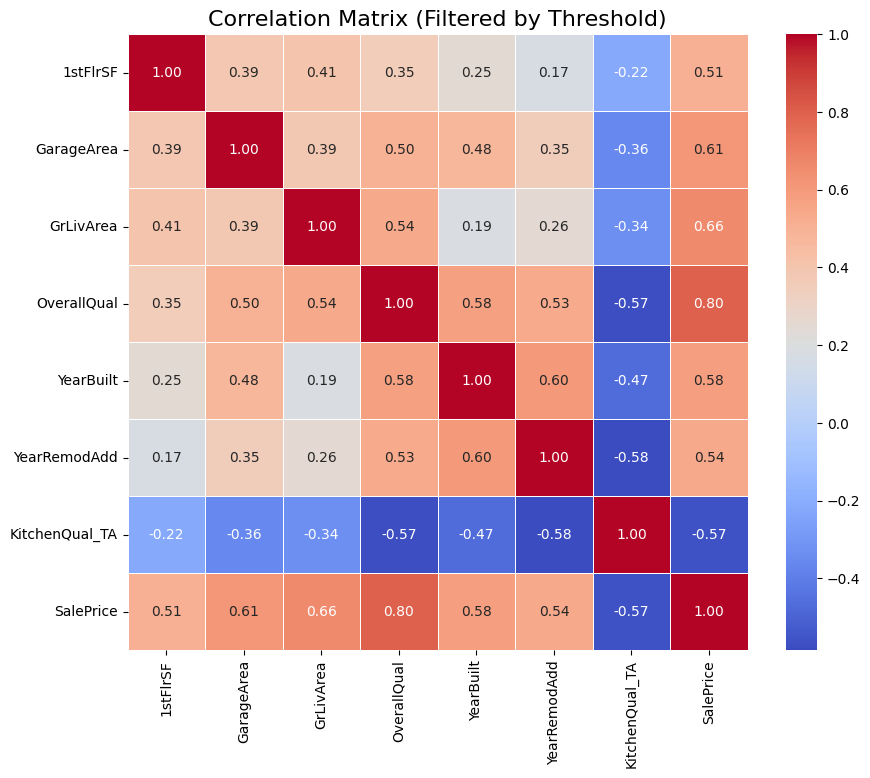

In [19]:
# Identify and OneHotEncode categorical variables
one_hot_encoder = OneHotEncoder(variables=['KitchenQual', 'GarageFinish', 'BsmtExposure', 'BsmtFinType1'])

# Apply OneHotEncoding on the transformed dataset
df_transformed_encoded = one_hot_encoder.fit_transform(df_transformed)

# Proceed with SmartCorrelatedSelection on the encoded dataset
df_numeric = df_transformed_encoded.select_dtypes(include=['float64', 'int64']).drop(columns=['SalePrice'])

# Apply SmartCorrelatedSelection
smart_corr = SmartCorrelatedSelection(
    method="spearman",          # Use rank correlation
    threshold=0.7,              # Correlation threshold
)
df_selected = smart_corr.fit_transform(df_numeric)

removed_features = smart_corr.features_to_drop_
print("Features removed due to high correlation:")
print(removed_features)

# Add 'SalePrice' back to the reduced dataset
df_selected['SalePrice'] = df_transformed_encoded['SalePrice']

# Check the correlation matrix after reduction
correlation_matrix_reduced = df_selected.corr()

# Filter features with high correlation with SalePrice
threshold = 0.5  # Set the threshold for correlation
high_corr_features = correlation_matrix_reduced.index[abs(correlation_matrix_reduced["SalePrice"]) > threshold]

# Create a heatmap with only the selected features
plt.figure(figsize=(10, 8))  # Adjust figure size
sns.heatmap(correlation_matrix_reduced.loc[high_corr_features, high_corr_features], 
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Filtered by Threshold)", fontsize=16)
plt.show()

The only change after scaling was the correlation between **GrLivArea** and **SalePrice**, which shifted slightly from 0.67 to 0.66. It remains a strong predictor.

___

In [20]:
# Filter correlations above a threshold in the reduced dataset
threshold = 0.5
correlation_matrix_reduced = df_selected.corr()  # Create the correlation matrix for df_selected
high_corr = correlation_matrix_reduced['SalePrice'][abs(correlation_matrix_reduced['SalePrice']) > threshold]
print("Variables with high correlation with SalePrice:")
print(high_corr.sort_values(ascending=False))


Variables with high correlation with SalePrice:
SalePrice         1.000000
OverallQual       0.796281
GrLivArea         0.662426
GarageArea        0.610261
YearBuilt         0.581749
YearRemodAdd      0.537774
1stFlrSF          0.507141
KitchenQual_TA   -0.565973
Name: SalePrice, dtype: float64


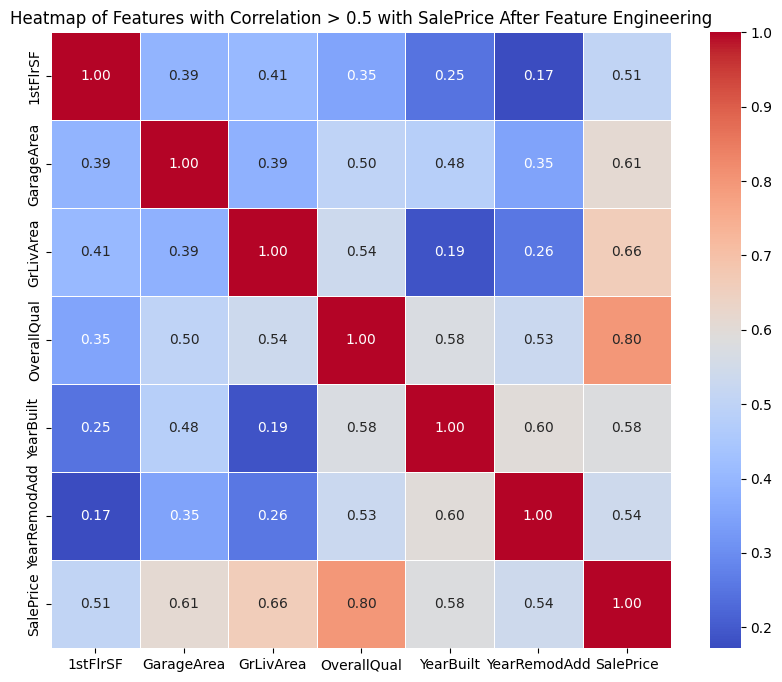

In [ ]:
# Generate the correlation matrix after feature engineering
correlation_matrix_after = df_selected.corr()

# Filter variables with correlation > 0.5 with SalePrice
threshold = 0.5
high_corr = correlation_matrix_after['SalePrice'][abs(correlation_matrix_after['SalePrice']) > threshold]

# Exclude negatively correlated features
high_corr = high_corr[high_corr > 0]  # Only keep positive correlations

# Get the names of relevant variables
relevant_vars = high_corr.index

# Update df_selected to include only relevant variables
df_selected = df_selected[relevant_vars]

# Create a filtered correlation matrix with only these variables
filtered_corr_matrix = correlation_matrix_after.loc[relevant_vars, relevant_vars]

# Plot heatmap for filtered variables
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Features with Correlation > 0.5 with SalePrice After Feature Engineering")
plt.show()

Display correlation matrix, helping identify relationships after feature engineering.

**Correlation Matrix After Feature Engineering**

The updated correlation matrix highlights how features relate to the target variable **"SalePrice"** after performing feature engineering. This analysis helps determine which features remain important and which newly engineered features contribute to better model predictions.

**Key Insights:**
Strong correlations with **SalePrice**:

* **OverallQual (0.80)** and **GrLivArea (0.66)** still show strong positive correlations, indicating their continued importance in predicting house prices.

* **GarageArea (0.61)** also maintain strong correlations, reinforcing its value in the model.

* **YearBuilt (0.58)** and **YearRemodAdd (0.54)** have similar positive correlations, showing that both features reflect the age and updates of the house, which are important for predicting its price.

**Newly engineered features:**

* None of the newly engineered features surpassed the threshold of 0.5 correlation with **SalePrice**.

This shows that even though new features were created, the original features are still the best for predicting house prices.

**Weak correlations with SalePrice:**

* Were removed because they don’t add much value to the model and can make predictions less accurate.

This matrix gives a clearer view after feature engineering, helping to find features that improve the model’s performance and those that might not be as useful.

___

* **Encode categorical variables:** Turn category columns into numbers so the model can use them.
* **Boolean columns:** Change True/False to 0 and 1 for the model.
* **Separate columns:** Split numeric and category columns to handle them better, like scaling numbers.

In [34]:
# Filter features with correlation > 0.5 with SalePrice
threshold = 0.5

# Compute the correlation matrix for df_selected
correlation_matrix = df_selected.corr()

# Select features with correlation > 0.5 with SalePrice
high_corr_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > threshold].index.tolist()

# Remove 'SalePrice' from the list
high_corr_features.remove('SalePrice')

# Keep only features strongly correlated with SalePrice (> 0.5)
X_combined = df_selected[high_corr_features].copy()

# Add SalePrice back to the dataset for visualization purposes
X_combined['SalePrice'] = df_selected['SalePrice']

print(f"Features selected based on correlation > {threshold}: {high_corr_features}")

Features selected based on correlation > 0.5: ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd']


* Combine columns to put all the numeric and encoded category columns together in one dataset.
* Scale numbers to make all numeric values similar in range to help the model work better.

In [35]:
# Create a pipeline to scale numbers
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

* Scale the numeric features so they are all on a similar range.
* Add 'SalePrice' to the transformed dataset.
* Print the dataset size, first few rows, and data types after transformation.
* Print an error message if something goes wrong.

In [36]:
try:
    # Scale numerical features using the pipeline
    X_combined_scaled = pd.DataFrame(pipeline.fit_transform(X_combined), columns=X_combined.columns)

    # Include SalePrice in the transformed dataset
    X_combined_scaled['SalePrice'] = df['SalePrice']

    # Display information about the transformed dataset
    print("Transformed dataset size:", X_combined_scaled.shape)
    print(X_combined_scaled.head())
    print(X_combined_scaled.dtypes)

except Exception as e:
    print("Error during pipeline execution:", e)


Transformed dataset size: (1290, 7)
   1stFlrSF  GarageArea  GrLivArea  OverallQual  YearBuilt  YearRemodAdd  \
0 -0.904021    0.392256   0.610259     0.735143   1.037855      0.873840   
1  0.346470   -0.059702  -0.443616    -0.070579   0.130080     -0.448768   
2 -0.706900    0.698241   0.764168     0.735143   0.970612      0.824855   
3 -0.580618    0.871010   0.624678     0.735143  -1.920817     -0.742681   
4 -0.013894    1.850150   1.513573     1.540864   0.936991      0.726884   

   SalePrice  
0   0.553334  
1   0.094270  
2   0.808369  
3  -0.611328  
4   1.258931  
1stFlrSF        float64
GarageArea      float64
GrLivArea       float64
OverallQual     float64
YearBuilt       float64
YearRemodAdd    float64
SalePrice       float64
dtype: object


___

In [37]:
# Print the shape and columns of the DataFrame to verify changes after operations
print("X_combined shape:", X_combined.shape)
print("Columns in X_combined:", X_combined.columns.tolist())


X_combined shape: (1290, 7)
Columns in X_combined: ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


Create a **heatmap** to visualize the correlation matrix **after** Feature Engineering

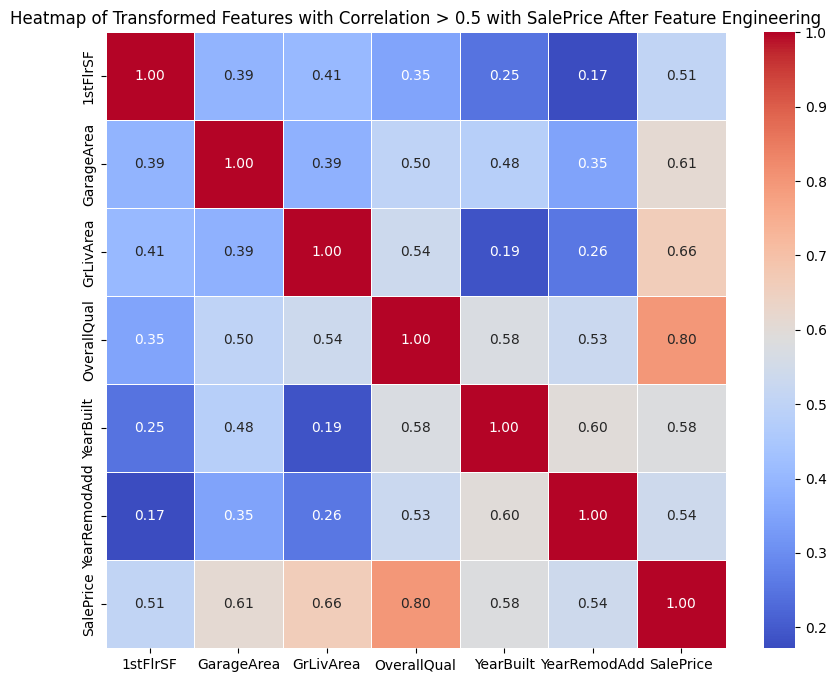

In [40]:
# Compute the correlation matrix for df_selected
correlation_matrix_after = df_selected.corr()

# Filter variables with correlation > 0.5 with SalePrice
threshold = 0.5
high_corr = correlation_matrix_after['SalePrice'][abs(correlation_matrix_after['SalePrice']) > threshold]

# Get the names of relevant variables
relevant_vars = high_corr.index

# Create a filtered correlation matrix with only these variables
filtered_corr_matrix = correlation_matrix_after.loc[relevant_vars, relevant_vars]

# Plot heatmap for variables with high correlation
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Transformed Features with Correlation > 0.5 with SalePrice After Feature Engineering")
plt.show()

**Correlation Matrix After Feature Engineering**

The updated correlation matrix shows that feature engineering did not change the correlations between the features and the target variable **SalePrice**.

* **OverallQual (0.80)** This feature has the strongest positive correlation with SalePrice, indicating that higher-quality homes tend to sell for more. This makes it a key predictor for the model.

* **GrLivArea (0.66)** and **GarageArea (0.61)** Both still show strong positive correlations with SalePrice, showing they are important for predicting house prices.

The feature engineering process aimed to explore new predictors and reduce redundancy, but the existing features remain the most significant contributors to the model. By focusing on strongly correlated features like OverallQual, GrLivArea, and GarageArea, the model can effectively predict house prices while avoiding the inclusion of less impactful features.

___

In [41]:
# Filter high correlation features related to SalePrice
high_corr_with_target = correlation_matrix['SalePrice'][correlation_matrix['SalePrice'] >= threshold]
print("Features with high correlation to SalePrice:", high_corr_with_target)

Features with high correlation to SalePrice: 1stFlrSF        0.507141
GarageArea      0.610261
GrLivArea       0.662426
OverallQual     0.796281
YearBuilt       0.581749
YearRemodAdd    0.537774
SalePrice       1.000000
Name: SalePrice, dtype: float64


In [42]:
print(X_combined.dtypes)

1stFlrSF        float64
GarageArea      float64
GrLivArea       float64
OverallQual     float64
YearBuilt       float64
YearRemodAdd    float64
SalePrice       float64
dtype: object


Print the number of unique values in each column

In [43]:
print(df.nunique())
print(df['SalePrice'].unique())

1stFlrSF        675
2ndFlrSF        360
BedroomAbvGr      7
BsmtExposure      4
BsmtFinSF1      574
BsmtFinType1      6
BsmtUnfSF       729
GarageArea      403
GarageFinish      3
GarageYrBlt      96
GrLivArea       766
KitchenQual       4
LotArea         683
LotFrontage     103
MasVnrArea      290
OpenPorchSF     182
OverallQual       8
TotalBsmtSF     650
YearBuilt       109
YearRemodAdd     61
SalePrice       569
dtype: int64
[ 5.53333604e-01  9.42699531e-02  8.08368966e-01 -6.11327881e-01
  1.25893144e+00 -5.60320809e-01  2.22806581e+00  4.08813566e-01
 -7.83051691e-01 -9.85379745e-01 -7.89852634e-01  2.87415540e+00
 -5.43318451e-01  1.76050098e+00 -3.22287804e-01 -7.47346741e-01
 -4.58306664e-01 -1.46144575e+00 -2.88283089e-01 -6.28330238e-01
  2.53920895e+00 -6.21529295e-01  9.18884289e-01 -3.73294877e-01
  1.36604629e+00 -6.99740140e-01  2.21106346e+00  5.36331247e-01
 -4.52355839e-01  6.70661812e-02 -1.77767766e-01  1.72649627e+00
  2.26207053e+00 -5.26316094e-01 -3.90297234e-0

### Hypothesis 1 Confirmed
The scatter plots and correlation analysis show a positive relationship between the total area of the house and its sale price, confirming the initial hypothesis that bigger houses tend to have higher sale prices.

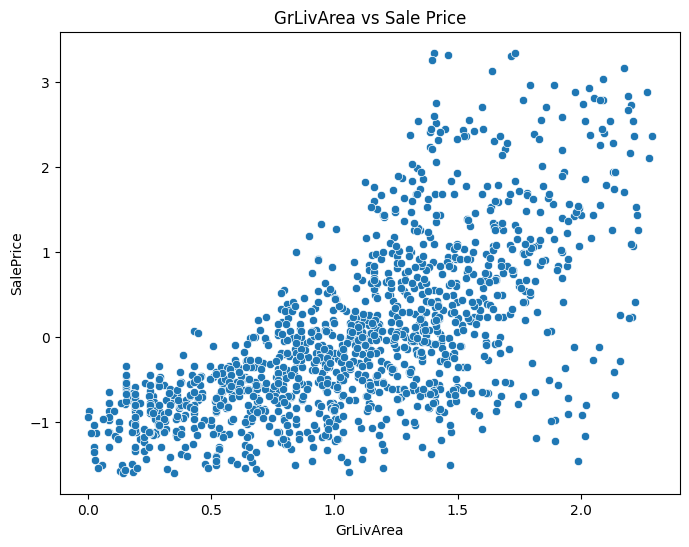

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=X_combined)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs Sale Price')
plt.show()

### Hypothesis 2 Confirmed
* The scatter plot and correlation analysis show a strong positive link between OverallQual and SalePrice. With a correlation of 0.80, higher quality homes tend to sell for more. This confirms that home quality affects its sale price.

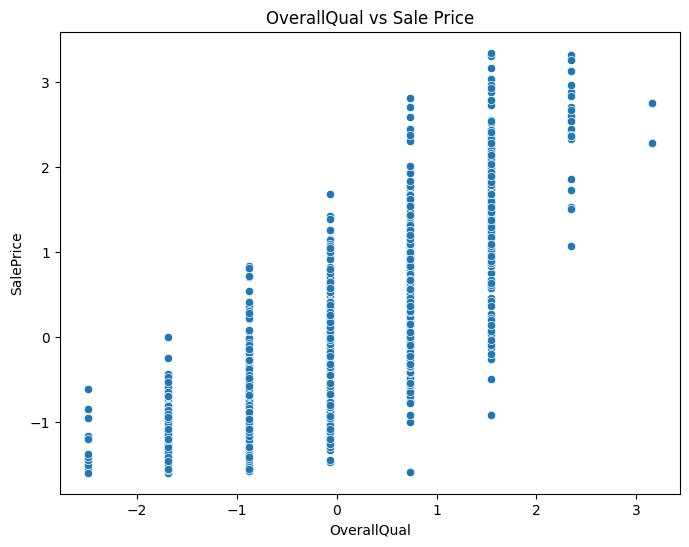

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=X_combined)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('OverallQual vs Sale Price')
plt.show()

### Hypothesis 3 Confirmed
The scatter plot and correlation analysis show a positive relationship between 'GarageArea' and 'SalePrice'. This confirms the hypothesis that houses with bigger garages tend to sell for higher prices.

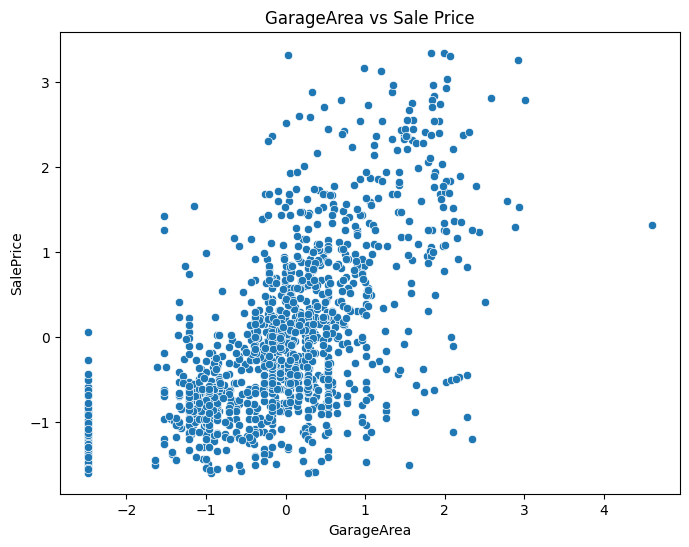

In [46]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GarageArea', y='SalePrice', data=X_combined)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.title('GarageArea vs Sale Price')
plt.show()

___

In [47]:
# Calculate the correlation between features and SalePrice using the latest dataset
correlation_after_engineering = X_combined.corr()['SalePrice'].sort_values(ascending=False)

# Select features that have a strong correlation (> 0.5) with SalePrice
selected_features_after_engineering = correlation_after_engineering[abs(correlation_after_engineering) > 0.5].index.tolist()

# Remove 'SalePrice' from the selected features
if 'SalePrice' in selected_features_after_engineering:
    selected_features_after_engineering.remove('SalePrice')

# Print the selected features
print(f"Features selected based on correlation > 0.5: {selected_features_after_engineering}")

# Filter the dataset to only keep the selected features and SalePrice
X_selected_after_engineering = X_combined[selected_features_after_engineering + ['SalePrice']]


Features selected based on correlation > 0.5: ['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', 'YearRemodAdd', '1stFlrSF']


## Push files to repo

In [50]:
# Export the filtered dataset with selected features
X_selected_after_engineering.to_csv("outputs/datasets/collection/HousePricesFeaturesSelected.csv", index=False)
print("Exported the selected features dataset successfully!")

Exported the selected features dataset successfully!


In [49]:
# Summary of Reduced Features
print("Feature Engineering Summary:")

# Total number of features in the dataset after feature engineering
print(f"Total number of features before reduction: {len(df_selected.columns)}")

# Total number of features selected after filtering based on correlation
print(f"Total number of features after reduction: {len(X_combined.columns)}")

# Number of features removed due to high correlation
print(f"Number of features removed due to correlation: {len(smart_corr.features_to_drop_)}")

# List of features removed due to high correlation
print(f"Removed features: {smart_corr.features_to_drop_}")


Feature Engineering Summary:
Total number of features before reduction: 7
Total number of features after reduction: 7
Number of features removed due to correlation: 4
Removed features: ['GarageYrBlt', 'TotalBsmtSF', 'KitchenQual_Gd', 'BsmtFinType1_Unf']


### Feature Engineering Summary

* No new features had a correlation higher than 0.5 with **SalePrice**, so they were not added to the final dataset.
* Original features like **GrLivArea (0.66)**, **OverallQual (0.80)**, and **GarageArea (0.61)** are still the best predictors of SalePrice.
* Visualizations showed a clear positive relationship between these features and **SalePrice**, confirming their importance.
* Features were scaled, one-hot encoded where needed, and checked for missing values to prepare them for modeling.
* Hypotheses 1, 2, and 3 were confirmed and added to the README.
* The final dataset is ready for modeling, with selected features that strongly relate to **SalePrice**.